In [121]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sn
import functions as fn
import functions as fn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, roc_auc_score, plot_confusion_matrix, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
#View options
#'display.float_format', lambda x: '%8.0f' % x
pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [3]:
#Import final polished dataframe
df = pd.read_csv('data/final.csv',encoding='cp1252')

In [4]:
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
df.shape

(73040, 23)

In [6]:
#Dealing with some missing school size data before transforming
df = df[df.Total_Students.apply(lambda x: x.isnumeric())]

In [7]:
#Transform all numerical data to appropriate datatypes
df['Total_Students'] = df['Total_Students'].astype(int)

In [8]:
#Found some nonsense values in Student/Teacher ratio column, need to replace with 16 (national average)
gibberish = df.loc[df['Student_Teacher_Ratio'] == 'Ã¢â‚¬â€œ']

In [9]:
df['level'] = np.nan

In [10]:
# Enumerate to replace values in ['Level'] to simplify variables
for i, element in enumerate(df['Level']): 
    if element == 'Secondary':
        df['level'][i] = 'High'
    elif element == 'Prekindergarten': 
        df['level'][i] = 'Other'
    elif element == 'Ungraded': 
        df['level'][i] = 'Other'
    elif element == 'Not applicable':
        df['level'][i] = 'Other' 
    else: 
        df['level'][i] = element

<ipython-input-10-3d3f8f40a880>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = element
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-10-3d3f8f40a880>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['level'][i] = 'High'
<ipython-input-10-3d3f8f40a880>:10: SettingWithCopy

In [11]:
df['level'].value_counts()

Elementary    40801
High          16288
Middle        13103
Other          2608
Name: level, dtype: int64

In [12]:
df = df.drop(['Level'], axis=1)

In [13]:
df = df.rename(columns={'level':'Level'})

In [14]:
#Need to fill Nans in Level column

In [15]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬â€œ','16',inplace=True)

In [16]:
df = df[df['Student_Teacher_Ratio'] != 'Ã¢â‚¬Â']

In [17]:
df['Student_Teacher_Ratio'].replace('Ã¢â‚¬Â\xa0','16',inplace=True)

In [18]:
df['Student_Teacher_Ratio'] = df['Student_Teacher_Ratio'].astype(float)

In [19]:
# Exploring balance of target classes
df['Target'].value_counts(normalize=True)

0    0.506308
1    0.493692
Name: Target, dtype: float64

In [20]:
#Splitting data into features and target
#Dropping all identifier columns including zipcode - as median income is based on zipcode and is a good stand-in
target = df['Target']
features = df.drop(['School_ID','School_Name','District_Name','District_ID','Zip','City','Target'], axis=1)               

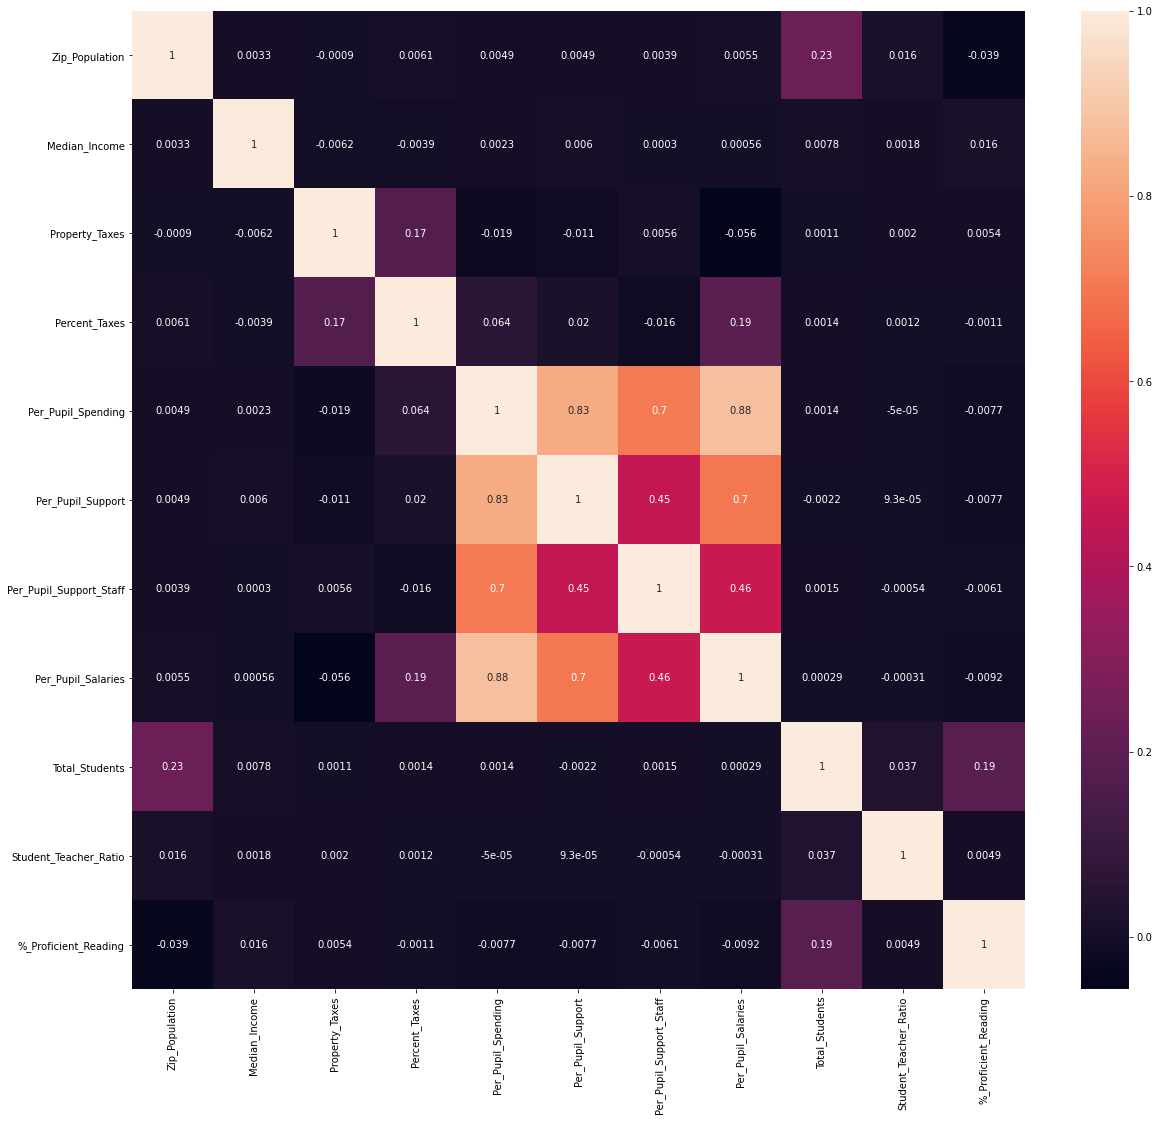

In [21]:
#Exploring multicollinearity
corr = features.corr()
pl.figure(figsize = (20,18))
sn.heatmap(corr, annot=True)
pl.show()

In [22]:
#Performing train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

### Dealing with Categorical Data

In [23]:
features.dtypes

State                       object
Zip_Population               int64
Density                     object
Median_Income                int64
Property_Taxes               int64
Percent_Taxes              float64
Per_Pupil_Spending           int64
Per_Pupil_Support            int64
Per_Pupil_Support_Staff      int64
Per_Pupil_Salaries           int64
Total_Students               int64
Student_Teacher_Ratio      float64
Title_I                     object
Virtual                     object
%_Proficient_Reading         int64
Level                       object
dtype: object

Since there are 50 state possibilities, one-hot encoding would lead to dozens of unnecessary columns. After some thought, I decided to use target encoding to deal with states, using the continuous version of the target to replace each state with the average percentage of students proficient in that state. Though this is an imperfect substitute for location, it is true that states differ markedly from each other in their levels of student achievement and tend to stay consistent from year to year (for example, Massachusetts is continually one of the top-performing states in the nation, while Louisiana is consistently one of the lowest). Thus, treating states this way should feed my model some valuable information about student performance.

In [24]:
#Target encoding state column 
#Create a groupby dataframe that gives us the mean in each numeric column for each state
state_averages = X_train.groupby(['State']).mean().reset_index()

In [25]:
state_averages = state_averages.filter(['%_Proficient_Reading','State'], axis=1).rename(columns={'%_Proficient_Reading':'State_Avg_Reading'})


In [26]:
#Join state helper dataframe with my training predictors and testing data
X_train = pd.merge(state_averages, X_train, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)
X_test = pd.merge(state_averages, X_test, how = 'inner', on='State').drop(['State','%_Proficient_Reading'], axis=1)

In [27]:
X_train.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level
0,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,39,4.18,yes,no,NaN
1,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,48,4.05,yes,no,NaN
2,35.559524,45366,midsize,61089,989357,47.9,10173,392,1145,3257,198,9.66,yes,yes,Elementary
3,35.559524,107571,urban,62602,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary
4,35.559524,12114,midsize,47060,7640,36.2,13364,661,223,4595,280,15.56,yes,yes,Elementary


In [28]:
#Deal with nulls in training and testing data
X_train = X_train.fillna(value = {"Level":"Other"})
X_test = X_test.fillna(value = {'Level':'Other'})

In [29]:
#Putting X back together
X = pd.concat([X_train, X_test], axis=0)

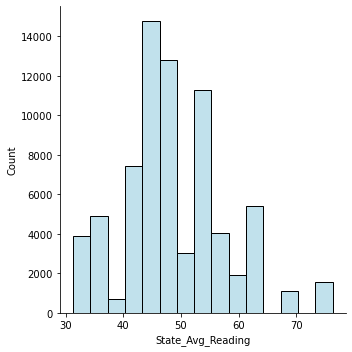

In [30]:
sn.displot(X, x='State_Avg_Reading', binwidth=3, color="lightblue")
pl.savefig("State Averages")

In [31]:
#Now need to one-hot encode  categorical columns
#Isolate categorical columns
cats = X[['Density','Title_I', 'Virtual','Level']]
#Transform data
cats = pd.get_dummies(cats)

In [32]:
cats.head()

,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,1,0,0,1,1,0,0,0,0,1
1,1,0,0,1,1,0,0,0,0,1
2,1,0,0,1,0,1,1,0,0,0
3,0,1,0,1,0,1,1,0,0,0
4,1,0,0,1,0,1,1,0,0,0


In [33]:
#Merge with main dataframe on key values
X_numeric = pd.concat([X, cats], axis=1)

In [34]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Density,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Title_I,Virtual,Level,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,39,4.18,yes,no,Other,1,0,0,1,1,0,0,0,0,1
1,35.559524,1410,midsize,72188,7518,35.6,10545,389,438,4049,48,4.05,yes,no,Other,1,0,0,1,1,0,0,0,0,1
2,35.559524,45366,midsize,61089,989357,47.9,10173,392,1145,3257,198,9.66,yes,yes,Elementary,1,0,0,1,0,1,1,0,0,0
3,35.559524,107571,urban,62602,6090,41.4,9813,581,616,3995,321,12.07,yes,yes,Elementary,0,1,0,1,0,1,1,0,0,0
4,35.559524,12114,midsize,47060,7640,36.2,13364,661,223,4595,280,15.56,yes,yes,Elementary,1,0,0,1,0,1,1,0,0,0


In [35]:
#Drop non-numeric categorical columns 
X_numeric = X_numeric.drop(['Density','Title_I', 'Virtual','Level'], axis=1)

In [36]:
X_numeric.head()

,State_Avg_Reading,Zip_Population,Median_Income,Property_Taxes,Percent_Taxes,Per_Pupil_Spending,Per_Pupil_Support,Per_Pupil_Support_Staff,Per_Pupil_Salaries,Total_Students,Student_Teacher_Ratio,Density_midsize,Density_urban,Title_I_no,Title_I_yes,Virtual_no,Virtual_yes,Level_Elementary,Level_High,Level_Middle,Level_Other
0,35.559524,1410,72188,7518,35.6,10545,389,438,4049,39,4.18,1,0,0,1,1,0,0,0,0,1
1,35.559524,1410,72188,7518,35.6,10545,389,438,4049,48,4.05,1,0,0,1,1,0,0,0,0,1
2,35.559524,45366,61089,989357,47.9,10173,392,1145,3257,198,9.66,1,0,0,1,0,1,1,0,0,0
3,35.559524,107571,62602,6090,41.4,9813,581,616,3995,321,12.07,0,1,0,1,0,1,1,0,0,0
4,35.559524,12114,47060,7640,36.2,13364,661,223,4595,280,15.56,1,0,0,1,0,1,1,0,0,0


In [37]:
#Have to re-do the train test split
X_train, X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

### Scaling Data

In [39]:
scaler = StandardScaler()
# Train our scaler on training data, then fit to testing
X_train_scaled = scaler.fit_transform(X_train, y=None)
X_test_scaled = scaler.transform(X_test)

### Baseline Modeling

Schools with below 50% proficiency) comprise the majority class. Could a baseline model do better than that?  

In [40]:
train = X_train.copy()
train['target'] = y_train.values

In [41]:
test = X_test
test['target'] = y_test

<ipython-input-41-fd87e67f2ec4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['target'] = y_test


In [42]:
len(train) + len(test)

72920

In [43]:
# Make baseline dataframe 
bdf = pd.concat([train,test],axis=0)

In [44]:
# Number correct is number of proficient districts with state proficiency > 50%
# and non-proficient districts with state proficiency < 50%.
prof_correct = len(bdf[(bdf['State_Avg_Reading']>50) & (bdf['target']==1)])
notprof_correct = len(bdf[(bdf['State_Avg_Reading']<50) & (bdf['target']==0)])

# Add totals
correct = prof_correct + notprof_correct
print(f'Baseline accuracy based on average statewide reading proficiency: {correct/len(bdf):.2}')

Baseline accuracy based on average statewide reading proficiency: 0.42


So a model that predicts a district's reading proficiency based on the overall average proficiency for the state in which the school is located only predicts correctly 42% of the time. We're better off just randomly guessing that a district is proficient!

### Logistic Regression Model

In [45]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [46]:
logreg.score(X_train_scaled, y_train)

0.5067539769610532

In [47]:
logreg.score(X_test_scaled, y_test)

0.4943773998902907

First logistic regression model did slightly better than baseline model, but still worse than randomly guessing the majority class. Hopefully our other classifier models can perform better. 

### K-Nearest Neighbors Model

In [48]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
#Predictions for the testing set
y_preds = knn.predict(X_test_scaled)

Train Scores
------------
Accuracy: 0.7492114646187603
Precision: 0.7492021479441536
F1 Score: 0.7447127800656105
ROC-AUC: 0.8120114737811422
--------------------
Test Scores
-----------
Accuracy: 0.502194185408667
Precision: 0.5021360035760132
F1 Score: 0.4940061332589908
ROC-AUC: 0.5016006679308551


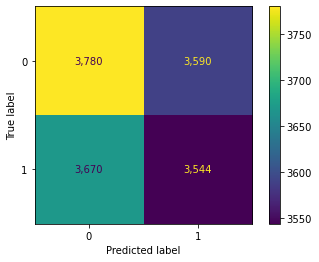

In [49]:
fn.evaluate(knn, X_train_scaled, X_test_scaled, y_train, y_test)

Overfitting appears to be a significant problem; training data does OK but precision score drops a ton on testing. Before turning to feature engineering or a grid search, I'm going to try a couple of other models to see how well they perform comparatively. 

### Random Forest Model

In [50]:
rf = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=0)
rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled) 

Train Scores
------------
Accuracy: 0.5435922929237521
Precision: 0.5801586293328131
F1 Score: 0.27921708763095915
ROC-AUC: 0.5814010905846668
--------------------
Test Scores
-----------
Accuracy: 0.5049369171695008
Precision: 0.5022952197919238
F1 Score: 0.21996542783059636
ROC-AUC: 0.5080112862860133


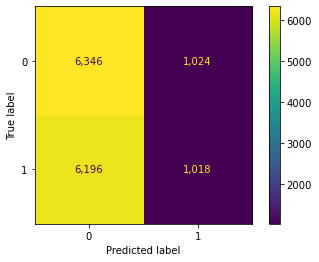

In [51]:
fn.evaluate(rf, X_train_scaled, X_test_scaled, y_train, y_test)

This has reduced overfitting somewhat, but precision has stayed mostly the same and is still about as accurate as random guessing.

### Gradient Boosting Model / XGBoost

In [52]:
#Trying sklearn gradient boosting instead
gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train_scaled, y_train)

In [53]:
gbmodel_preds = gbmodel.predict(X_test_scaled)

Train Scores
------------
Accuracy: 0.5311300054854635
Precision: 0.5317051846741114
F1 Score: 0.4520833333333333
ROC-AUC: 0.54350613424485
--------------------
Test Scores
-----------
Accuracy: 0.505759736697751
Precision: 0.5047068330570754
F1 Score: 0.425931825422109
ROC-AUC: 0.5034476532326898


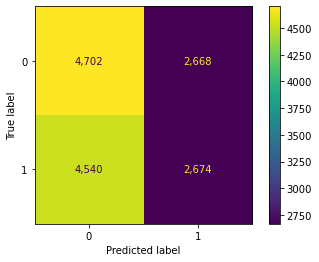

In [54]:
fn.evaluate(gbmodel, X_train_scaled, X_test_scaled, y_train, y_test)

Using gradient boosting did not appear to have any discernible improvement for my model. However, the gap in precision scores between training and testing models was the smallest here out of any of the three algorithms.

### AdaBoost Classifier

In [122]:
ada = AdaBoostClassifier()
ada.fit(X_train_scaled, y_train)

AdaBoostClassifier()

Train Scores
------------
Accuracy: 0.5242731760833791
Precision: 0.5246260599232768
F1 Score: 0.4314512824715234
ROC-AUC: 0.5346677947766252
--------------------
Test Scores
-----------
Accuracy: 0.5072682391662096
Precision: 0.5062378712993225
F1 Score: 0.41204385534282445
ROC-AUC: 0.505746157686001


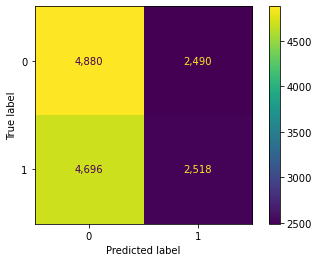

In [125]:
fn.evaluate(ada, X_train_scaled, X_test_scaled, y_train, y_test)

### Feature Engineering and Model Improvement

In [55]:
importances = rf.feature_importances_

In [57]:
feature_names = X_test.drop(labels='target', axis=1)

In [58]:
rf_importances = pd.DataFrame(index=feature_names.columns, data=importances).sort_values(by=0,ascending=False)

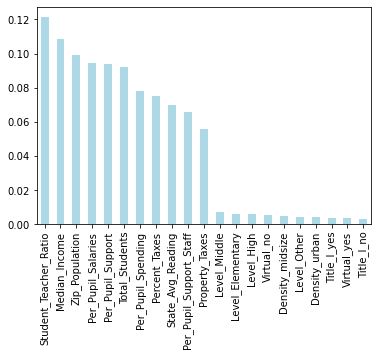

In [60]:
# plot feature importance
rf_importances.plot(kind='bar', legend=False, color='lightblue');

As a first try, I'm going to select only the top eight features with an importance of over .06 and rerun the models to see if these improve precision scores. As an added bonus, this feature selection might make my models more interpretable. Since my gradient boosting model seemed the most effective when it came to minimizing overfitting, I will re-run this algorithm on my new features.

In [74]:
top8_X_numeric = X_numeric[['Student_Teacher_Ratio','Median_Income','Zip_Population','Per_Pupil_Salaries','Per_Pupil_Support','Total_Students','Per_Pupil_Spending','Percent_Taxes']]



In [75]:
#Have to re-do the train test split
top8_X_train, top8_X_test, y_train, y_test = train_test_split(X_numeric, target, test_size=0.20, random_state=42)

In [77]:
#Scale the data again
top8_X_train_scaled = scaler.fit_transform(top8_X_train, y=None)
top8_X_test_scaled = scaler.transform(top8_X_test)

In [81]:
#Run Gradient Boosting 
top8_gbmodel = GradientBoostingClassifier(n_estimators=100,
max_depth=1, random_state=0).fit(top8_X_train_scaled, y_train)

In [82]:
top8_gbmodel_preds = top8_gbmodel.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.5149993143170598
Precision: 0.5172668979751646
F1 Score: 0.3001459420684196
ROC-AUC: 0.5249659339242155
--------------------
Test Scores
-----------
Accuracy: 0.5054168952276468
Precision: 0.5034960439338292
F1 Score: 0.29096628329892854
ROC-AUC: 0.5108552776355639


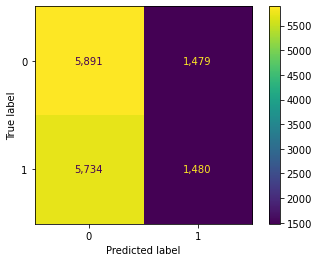

In [83]:
fn.evaluate(top8_gbmodel, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)

Selecting features had no discernible effect on my model. Going to try tuning some of the more important hyperparameters next, such as learning rate.

In [84]:
X_numeric.shape

(72920, 21)

In [85]:
#Seeing how models performs with default parameters
default = GradientBoostingClassifier().fit(top8_X_train_scaled, y_train)

In [86]:
default_preds = default.predict(top8_X_test_scaled)

Train Scores
------------
Accuracy: 0.5555231760833791
Precision: 0.5599924615875593
F1 Score: 0.4609915809167446
ROC-AUC: 0.5865065334800958
--------------------
Test Scores
-----------
Accuracy: 0.5063082830499177
Precision: 0.5051731051550702
F1 Score: 0.4103194103194103
ROC-AUC: 0.5101893687045278


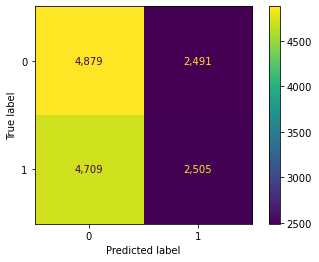

In [87]:
fn.evaluate(default, top8_X_train_scaled, top8_X_test_scaled, y_train, y_test)


With default parameters, precision score went up slightly (by .02%); however, overfitting also worsened slightly. Going to try a GridSearch CV next. 

loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0

In [93]:
X_numeric.shape

(72920, 21)

**min_samples_split = 700**: min_samples should be ~.05 - 1% of total values. Since this is a balanced class problem, will take towards the larger end of the range. 1% of 72920 is about 700.

**max_depth = 7**: Should be chosen (5-8) based on the number of observations and predictors. This has 72K rows and 21 columns so lets take 7 here.

**max_features = sqrt**: Rule of thumb.

**subsample == 0.8**: Commonly used start value.

In [119]:
#Creating scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

# A sample parameter
parameters = {
    "min_samples_split": [100],
    "max_depth":[7],
    "max_features":["sqrt"],
    "subsample":[0.8],
    "n_estimators":range(20,81,10)
    }
#Passing the scoring function in the GridSearchCV
clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)

clf.fit(top8_X_train_scaled, y_train)
#Converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(clf.cv_results_)
#Here are inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

,split0_test_accuracy,split1_test_accuracy,split0_test_precision,split1_test_precision,split0_test_recall,split1_test_recall
0,0.501680,0.506960,0.493174,0.500594,0.356423,0.351212
1,0.502297,0.500206,0.494509,0.491702,0.387966,0.380810
2,0.497840,0.502503,0.489173,0.494798,0.398666,0.389912
3,0.500583,0.499486,0.492813,0.491363,0.414507,0.407142
4,0.503154,0.502983,0.495904,0.495727,0.416383,0.419162
5,0.499383,0.498800,0.491459,0.490874,0.417773,0.422289
6,0.501920,0.498080,0.494663,0.490049,0.434656,0.422567


In [120]:
#find the best parameter based on the accuracy_score
#taking the average of the precision
df['precision_score']=(df['split0_test_precision']+df['split1_test_precision'])/2

df.loc[df['precision_score'].idxmax()]['params']

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 20,
 'subsample': 0.8}